In [2]:
#open pkl file
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('/hdfs1/Data/Shubhajit/Sub-Structure-GNN/data/chembl.pkl', 'rb') as f:
    chembl_data = pickle.load(f)

In [18]:
chembl_data[0]

'C1C2C3CC4C2C2C1C3[C@H](NCC13C5C6C7C5C1C7C63)C42'

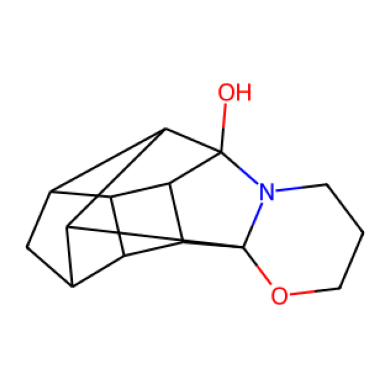

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

# SMILES notation for the molecule
smiles = chembl_data[1]

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Generate 2D coordinates for visualization
AllChem.Compute2DCoords(mol)

# Draw and display the molecular graph
img = Draw.MolToImage(mol)
plt.imshow(img)
plt.axis('off')
plt.show()

In [34]:
from torch_geometric.utils import degree
import torch.utils.data
import warnings
from torch_geometric.data import Data, InMemoryDataset, download_url, Batch
from dgl.data.utils import Subset, load_graphs
import torch
from torch_geometric.utils import k_hop_subgraph, to_undirected
from scipy.special import comb

class Dataset_1_orig(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_1_orig, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset1_orig.pt']

    def download(self):
        pass

    def count_triangle(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        if num_nodes > 0:
            node_name = torch.unique(edge_index[0])
        else:
            return torch.tensor([0])
        num_edges = 0
        for ind in node_name:
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind.item(), 1, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            num_edges += edge_index_.shape[1]
        return torch.tensor([num_edges//6])

    def count_K4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            data_ = Data(edge_index=edge_index_, z=z_)
            l = torch.cat((l, self.count_triangle(data_)), dim=0)

        return torch.sum(l)//4

    def count_2star(self, data):
        egde_index, num_nodes = data.edge_index, data.num_nodes
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, egde_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ == ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            k = torch.cat(
                (k, torch.tensor([comb(nodes_.shape[0]-1, 2, exact=True)])), dim=0)
        return torch.sum(k)

    def count_chordal(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            total_edge_index = torch.cat(
                (total_edge_index, edge_index_.T), dim=0)
            nodes_ = nodes_[nodes_ != ind]
            deg = degree(edge_index_[0], num_nodes)
            ll = sum([comb(i, 2, exact=True) for i in deg[deg > 1]])
            l = torch.cat((l, torch.tensor([ll])), dim=0)
        return torch.sum(l)//2

    def countC4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [
                n, ind] in edge_list else 0 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()

            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [
                          m, n] in edge_list and node_dict[m] == 1])
                if nei >= 2:
                    ll += comb(nei, 2, exact=True)

            l = torch.cat((l, torch.tensor([ll])), dim=0)

        return torch.ceil(torch.sum(l)/4)

    def from_dgl(self, g, star, tri, tail_tri, attr_tri, chord):
        import dgl

        from torch_geometric.data import Data, HeteroData

        if not isinstance(g, dgl.DGLGraph):
            raise ValueError(f"Invalid data type (got '{type(g)}')")

        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[attr] = value
        for attr, value in g.edata.items():
            data[attr] = value

        data.C4 = self.countC4(data)
        data.star = star.item()
        data.triangle = tri.item()
        data.tailed_triangle = tail_tri.item()
        data.attributed_triangle = attr_tri.item()
        data.chordal_cycle = self.count_chordal(data)
        data.star_2 = self.count_2star(data)
        data.K4 = self.count_K4(data)
        return data

    def process(self):
        glist, all_labels = load_graphs(
            "/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/dataset1.bin")
        data_list = []
        for i in zip(glist, all_labels["star"], all_labels["triangle"], all_labels["tailed_triangle"], all_labels["attributed_triangle"], all_labels["chordal_cycle"]):
            data = self.from_dgl(i[0], i[1], i[2], i[3], i[4], i[5])
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


class Dataset_2_orig(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_2_orig, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset2_orig.pt']

    def download(self):
        pass

    def count_triangle(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        if num_nodes > 0:
            node_name = torch.unique(edge_index[0])
        else:
            return torch.tensor([0])
        num_edges = 0
        for ind in node_name:
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind.item(), 1, edge_index, False, num_nodes)
            edge_attr_ = None
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            num_edges += edge_index_.shape[1]
        return torch.tensor([num_edges//6])

    def count_K4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            data_ = Data(edge_index=edge_index_, z=z_)
            l = torch.cat((l, self.count_triangle(data_)), dim=0)

        return torch.sum(l)//4

    def count_2star(self, data):
        egde_index, num_nodes = data.edge_index, data.num_nodes
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, egde_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ == ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            k = torch.cat(
                (k, torch.tensor([comb(nodes_.shape[0]-1, 2, exact=True)])), dim=0)
        return torch.sum(k)

    def count_chordal(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 1, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            total_edge_index = torch.cat(
                (total_edge_index, edge_index_.T), dim=0)
            nodes_ = nodes_[nodes_ != ind]
            deg = degree(edge_index_[0], num_nodes)
            ll = sum([comb(i, 2, exact=True) for i in deg[deg > 1]])
            l = torch.cat((l, torch.tensor([ll])), dim=0)
        return torch.sum(l)//2

    def countC4(self, data):
        edge_index, num_nodes = data.edge_index, data.num_nodes
        l = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            node_dict = {}
            nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                ind, 2, edge_index, False, num_nodes)
            edge_index_ = edge_index_.T
            nodes_ = nodes_[nodes_ != ind]
            edge_list = edge_index_.tolist()
            node_dict = {n.item(): 1 if [ind, n] in edge_list or [
                n, ind] in edge_list else 0 for n in nodes_}
            mask = (edge_index_ != ind).all(dim=1)
            edge_index_ = edge_index_[mask].T
            ll = 0
            edge_list = edge_index_.T.tolist()

            for n in node_dict:
                nei = sum([1 for m in node_dict if [n, m] in edge_list and [
                          m, n] in edge_list and node_dict[m] == 1])
                if nei >= 2:
                    ll += comb(nei, 2, exact=True)

            l = torch.cat((l, torch.tensor([ll])), dim=0)

        return torch.ceil(torch.sum(l)/4)

    def from_dgl(self, g, star, tri, tail_tri, attr_tri, chord):
        import dgl

        from torch_geometric.data import Data, HeteroData

        if not isinstance(g, dgl.DGLGraph):
            raise ValueError(f"Invalid data type (got '{type(g)}')")

        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[attr] = value
        for attr, value in g.edata.items():
            data[attr] = value

        data.C4 = self.countC4(data)
        data.star = star.item()
        data.triangle = tri.item()
        data.tailed_triangle = tail_tri.item()
        data.attributed_triangle = attr_tri.item()
        data.chordal_cycle = self.count_chordal(data)
        data.star_2 = self.count_2star(data)
        data.K4 = self.count_K4(data)
        return data

    def process(self):
        glist, all_labels = load_graphs(
            "/hdfs1/Data/Shubhajit/WL_Substructure_Counting/data/dataset2.bin")
        data_list = []
        for i in zip(glist, all_labels["star"], all_labels["triangle"], all_labels["tailed_triangle"], all_labels["attributed_triangle"], all_labels["chordal_cycle"]):
            data = self.from_dgl(i[0], i[1], i[2], i[3], i[4], i[5])
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

class Dataset_chembl(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(Dataset_chembl, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['dataset_chembl.pt']

    def download(self):
        pass


    def from_chembl(self, molecule):
        mol = Chem.MolFromSmiles(molecule)
        # Get atom and bond information
        atoms = mol.GetAtoms()
        bonds = mol.GetBonds()
        edge_list = []

        # Add bonds to the edge list
        for bond in bonds:
            atom1_idx = bond.GetBeginAtomIdx()
            atom2_idx = bond.GetEndAtomIdx()
            edge_list.append([atom1_idx, atom2_idx])

        data = Data()
        data.edge_index = to_undirected(torch.tensor(edge_list, dtype=torch.long).t().contiguous())
        data.triangle = torch.tensor([0])
        data.star = torch.tensor([0])
        data.chordal_cycle = torch.tensor([0])
        data.star_2 = torch.tensor([0])
        data.K4 = torch.tensor([0])
        data.tailed_triangle = torch.tensor([0])
        data.C4 = torch.tensor([0])
        return data

    def process(self):
        with open('/hdfs1/Data/Shubhajit/Sub-Structure-GNN/data/chembl.pkl', 'rb') as f:
            chembl_data = pickle.load(f)
        data_list = []
        for i in chembl_data:
            data = self.from_chembl(i)
            data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [35]:
dataset = Dataset_chembl(root="data/Dataset_chembl", pre_transform=None)

Processing...
Done!


In [36]:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = dataset[int(len(dataset)*0.9):]

In [65]:
import torch
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from scipy.special import comb
from torch_geometric.utils import degree
class collater():
    def __init__(self, task):
        self.task = task
        pass

    def create_subgraphs(self, data):

        edge_index, num_nodes = data.edge_index, data.num_nodes
        print("edge index:",edge_index)
        num_edges = 0
        subgraphs = {}
        total_edge_index = torch.tensor([], dtype=torch.long)
        l = torch.tensor([], dtype=torch.long)
        k = torch.tensor([], dtype=torch.long)
        for ind in range(num_nodes):
            if self.task == "triangle":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                print("root node:",ind)
                print("rooted subgraph:",edge_index_)
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] != ind and edge[1] != ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                print("new edge index:",edge_index_)
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                total_edge_index = torch.cat((total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                l = torch.cat(
                    (l, torch.tensor([edge_index_.shape[1]//2])), dim=0)
                num_edges += edge_index_.shape[1]

            elif self.task == "3star":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] == ind or edge[1] == ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                total_edge_index = torch.cat(
                    (total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                l = torch.cat(
                    (l, torch.tensor([comb(edge_index_.shape[1]//2, 3, exact=True)])), dim=0)
                k = torch.cat(
                    (k, torch.tensor([comb(edge_index_.shape[1]//2, 3, exact=True)])), dim=0)

            elif self.task == "chordal":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_attr_ = None
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] != ind and edge[1] != ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                total_edge_index = torch.cat(
                    (total_edge_index, edge_index_.T), dim=0)
                data_ = Data(edge_index=edge_index_, z=z_)
                nodes_ = nodes_[nodes_ != ind]
                deg = degree(edge_index_[0], num_nodes)
                ll = sum([comb(i, 2, exact=True) for i in deg[deg > 1]])
                l = torch.cat((l, torch.tensor([ll])), dim=0)
                k = torch.cat((k, torch.tensor([ll])), dim=0)

            elif self.task == "2star":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] == ind or edge[1] == ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                data_ = Data(edge_index=edge_index_, z=z_)
                k = torch.cat(
                    (k, torch.tensor([comb(edge_index_.shape[1]//2, 2, exact=True)])), dim=0)
                l = torch.cat(
                    (l, torch.tensor([comb(edge_index_.shape[1]//2, 2, exact=True)])), dim=0)

            elif self.task == "local_nodes":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] == ind or edge[1] == ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                data_ = Data(edge_index=edge_index_, z=z_)
                k = torch.cat(
                    (k, torch.tensor([edge_index_.shape[1]//2])), dim=0)
                l = torch.cat(
                    (l, torch.tensor([edge_index_.shape[1]//2])), dim=0)

            elif self.task == "local_edges":
                nodes_, edge_index_, edge_mask_, z_ = k_hop_subgraph(
                    ind, 1, edge_index, False, num_nodes)
                edge_index_ = edge_index_.T
                new_edge_index = torch.tensor([], dtype=torch.long)
                for edge in edge_index_:
                    if edge[0] != ind and edge[1] != ind:
                        new_edge_index = torch.cat(
                            (new_edge_index, edge.unsqueeze(0)), dim=0)
                edge_index_ = new_edge_index.T
                if len(edge_index_.shape) == 1:
                    edge_index_ = edge_index_.reshape(2, edge_index_.shape[0])
                data_ = Data(edge_index=edge_index_, z=z_)
                k = torch.cat(
                    (k, torch.tensor([edge_index_.shape[1]//2])), dim=0)
                l = torch.cat(
                    (l, torch.tensor([edge_index_.shape[1]//2])), dim=0)

            subgraphs[ind] = data_

        total_edge_index = torch.unique(total_edge_index, dim=0)

        if self.task == "triangle":
            new_data = Data(edge_index=total_edge_index.T)
            new_data.ext_label_dataset = data.triangle
            new_data.ext_label = torch.tensor([num_edges//6])
        elif self.task == "3star":
            new_data = Data(edge_index=data.edge_index)
            new_data.ext_label_dataset = data.star
            new_data.ext_label = torch.sum(k)
        elif self.task == "chordal":
            new_data = Data(edge_index=edge_index)
            new_data.ext_label_dataset = data.chordal_cycle
            new_data.ext_label = torch.sum(k)//2
        elif self.task == "2star":
            new_data = Data(edge_index=data.edge_index)
            new_data.ext_label_dataset = data.star_2
            new_data.ext_label = torch.sum(k)
        elif self.task == "local_nodes":
            new_data = Data(edge_index=data.edge_index)
            # new_data.ext_label_dataset = data.local_nodes
            new_data.ext_label = torch.sum(k)
        elif self.task == "local_edges":
            new_data = Data(edge_index=data.edge_index)
            # new_data.ext_label_dataset = data.local_nodes
            new_data.ext_label = torch.sum(k)
        print("internal label",l)
        print("external label",new_data.ext_label)
        return new_data, subgraphs, l

    def __call__(self, data):
        graphs = []
        subgraphs = []
        max_nodes = max([d.num_nodes for d in data])
        labels = torch.zeros((len(data), max_nodes), dtype=torch.long)
        for g in data:
            G_, sub_G, internal_labels = self.create_subgraphs(g)
            graphs.append(G_)
            subgraphs.append(sub_G)
            labels[len(graphs)-1, :g.num_nodes] = internal_labels

        return [graphs, subgraphs, labels, max_nodes]


In [76]:

from torch.utils.data import DataLoader
collater_fn = collater('triangle')
train_loader = DataLoader(train_dataset, batch_size=1,
                              shuffle=True, drop_last=True, collate_fn=collater_fn)

In [87]:
for batch in train_loader:
    batch
    break

edge index: tensor([[ 0,  1,  1,  1,  1,  2,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,  8,
          8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 15,
         15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 21, 21, 22, 22, 23, 23,
         24, 24],
        [ 1,  0,  2,  3,  4,  1,  1,  1,  5, 24,  4,  6,  5,  7,  6,  8, 23,  7,
          9, 10,  8, 10,  8,  9, 11, 10, 12, 22, 11, 13, 12, 14, 13, 15, 22, 14,
         16, 21, 15, 17, 16, 18, 17, 19, 18, 20, 21, 19, 15, 19, 11, 14,  7, 24,
          4, 23]])
root node: 0
rooted subgraph: tensor([[0, 1],
        [1, 0]])
new edge index: tensor([], dtype=torch.int64)
root node: 1
rooted subgraph: tensor([[0, 1, 1, 1, 1, 2, 3, 4],
        [1, 0, 2, 3, 4, 1, 1, 1]])
new edge index: tensor([], dtype=torch.int64)
root node: 2
rooted subgraph: tensor([[1, 2],
        [2, 1]])
new edge index: tensor([], dtype=torch.int64)
root node: 3
rooted subgraph: tensor([[1, 3],
        [3, 1]])
new edge index: tensor([], dtype=torch.

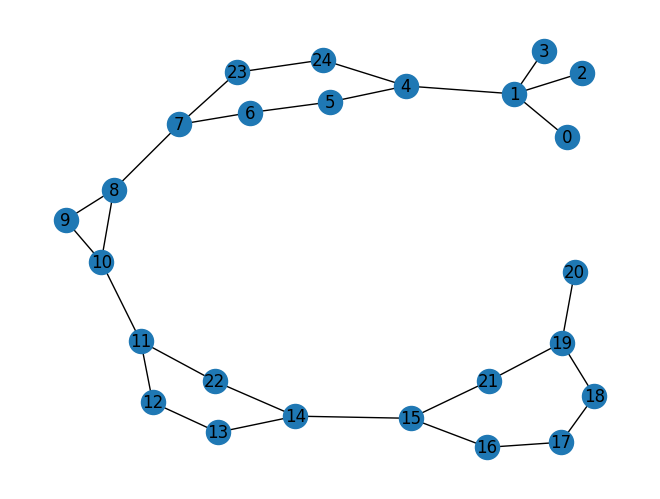

In [88]:
plot_edge = torch.tensor([[ 0,  1,  1,  1,  1,  2,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,  8,
          8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 14, 14, 15,
         15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 21, 21, 22, 22, 23, 23,
         24, 24],
        [ 1,  0,  2,  3,  4,  1,  1,  1,  5, 24,  4,  6,  5,  7,  6,  8, 23,  7,
          9, 10,  8, 10,  8,  9, 11, 10, 12, 22, 11, 13, 12, 14, 13, 15, 22, 14,
         16, 21, 15, 17, 16, 18, 17, 19, 18, 20, 21, 19, 15, 19, 11, 14,  7, 24,
          4, 23]])

plot_edge = plot_edge.T
#plot a graph
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edges_from(plot_edge.numpy())
nx.draw(G, with_labels=True)
plt.show()


In [8]:
#load zinc dataset
from torch_geometric.datasets import ZINC

train_dataset = ZINC(root='/hdfs1/Data/Shubhajit/Sub-Structure-GNN/data/ZINC', subset=False, split='train', pre_transform=None)
test_dataset = ZINC(root='/hdfs1/Data/Shubhajit/Sub-Structure-GNN/data/ZINC', subset=False, split='test', pre_transform=None)
val_dataset = ZINC(root='/hdfs1/Data/Shubhajit/Sub-Structure-GNN/data/ZINC', subset=False, split='val', pre_transform=None)


Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 10023.62it/s]
Done!
